BIOINF585: Machine-Learning

HW01-An exploration of k-mean clustering and distance measures given two datasets

I approached this using python/pandas/scipy in an ipython notebook.
The first several cells are the main code blocks, primarily functions.
The exploration of datasets 1 and 2 follow with a summary graph at the end.
Brief narrative comments appear throughout.


In [2]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
import random
from scipy.io import loadmat
from scipy.spatial import distance


In [3]:
random.seed(42)
ALL_MARKERS = ['o','x', 'd', 'h', '*', 'p', 's']
ALL_COLORS = ['red', 'blue']

In [4]:
def load_feature_group_matrices(filename, plot=False):
    '''Return feature (sample x feature) and group (sample x group) dataframes from specified matlab file'''
    mat = loadmat(filename)
    feature_df = pd.DataFrame(mat['A']).transpose()
    feature_df.columns = ['f1', 'f2']
    group_df = pd.DataFrame(mat['Z']).transpose()
    group_df.columns = ['expected']
    if plot:
        plt.scatter(x=feature_df.f1[group_df.expected==0], y=feature_df.f2[group_df.expected==0], alpha=0.5, marker=ALL_MARKERS[0], color="black")
        plt.scatter(x=feature_df.f1[group_df.expected==1], y=feature_df.f2[group_df.expected==1], alpha=0.5, marker=ALL_MARKERS[1], color="black")
        plt.show()
    
    return feature_df, group_df

In [16]:
def k_means(feature_df, group_df, k, distance_metric, show_stats=False):
    '''Return a series (column) of k-means groups, center, and incorrect groups 
    based on features and distance metric.
    
    feature_df: sample x feature matrix of n-dim vectors
    group_df: vector of expecetd sample group
    k: num k-means groups
    distance_metric'''
    
    #Initialize centers from randomly selected samples
    center_indices = random.sample(range(0, len(feature_df)), k)
    centers_df = feature_df.ix[center_indices,].reset_index(drop=True)
    
    #Iterate k-means grouping, updating center each iteration until groupings are stable 
    grouping_df = pd.DataFrame()
    samples_changed = None;
    iteration = 0
    last_grouping = None
    while samples_changed != 0:
        iteration += 1
        this_grouping = "group_iter" + str(iteration)     
        dist={}
        for center in centers_df.itertuples():
            group_num = center[0]
            center = center[1:]
            dist[group_num] = feature_df.apply(lambda s: distance_metric(s, center), axis=1)

        grouping_df[this_grouping] = pd.DataFrame(dist).idxmin(axis=1)

        center = {}
        for group_num, group in grouping_df.groupby(this_grouping):
            center[group_num] = np.mean(feature_df[grouping_df[this_grouping] == group_num])
        centers_df = pd.DataFrame(center).transpose()


        if last_grouping:
            samples_changed = len(grouping_df[grouping_df[last_grouping] != grouping_df[this_grouping]])

        last_grouping = this_grouping

        samples_in_incorrect_group = len(grouping_df[group_df.expected != grouping_df[this_grouping]])
        if show_stats:
            print("{}: samples_changed={} incorrect_samples={}".format(this_grouping,
                                                                       samples_changed,
                                                                       samples_in_incorrect_group))

        if samples_changed == 0:
            #stupid hack to handle when group assignments flop
            if samples_in_incorrect_group > len(feature_df)/2:
                samples_in_incorrect_group = len(feature_df) - samples_in_incorrect_group
            print("incorrect_samples={}".format(samples_in_incorrect_group))
    return grouping_df[this_grouping], center, samples_in_incorrect_group

In [8]:
#TODO extend to support arbitrary number of expected groups
def plot_groups(feature_df, group_df, center):
    groups = pd.concat([feature_df, group_df], axis=1).groupby("actual")
    for group_num, group in groups:
        colors = group.actual.apply(lambda x: ALL_COLORS[x])
        plt.scatter(x=group.f1[group.expected==0], y=group.f2[group.expected==0], alpha=0.5, marker=ALL_MARKERS[0], color=colors)
        plt.scatter(x=group.f1[group.expected==1], y=group.f2[group.expected==1], alpha=0.5, marker=ALL_MARKERS[1], color=colors)
        plt.scatter(x=center[group_num][0], y=center[group_num][1], marker=ALL_MARKERS[group_num], alpha=0.5, color="green")
    plt.show()

In [10]:
def run_multiple_k_means(run_stat, description, num_runs, feature_df, group_df):
    '''Run a k-means cluster multiple times in both euclidean and mahalanobis distances 
    appending results to run_stat dict'''
    print(description)
    for i in xrange(0, num_runs):
        x,y,incorrect=k_means(feature_df, 
                              group_df, 
                              2, 
                              distance.euclidean)
        run_stat.append({"description": description, "distance":"euclidean", "run": i, "incorrect": incorrect})
        x,y,incorrect = k_means(feature_df, 
                                group_df, 
                                2, 
                                lambda x,c : distance.mahalanobis(x, c, inv(feature_df.cov().as_matrix())))
        run_stat.append({"description": description, "distance":"mahalanobis", "run": i, "incorrect": incorrect})


Exploring the "easy" dataset
----------------------------

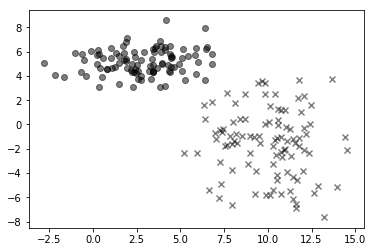

In [12]:
feature_df, group_df = load_feature_group_matrices("easy.mat", plot=True)

Expected groups are identified by symbol (dot is group 0, cross is group 1). These are clearly linearly-separable groups. 

incorrect_samples=0


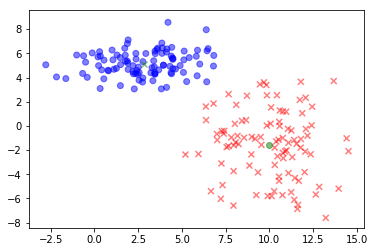

In [18]:
group_df['actual'], center, incorrect = k_means(feature_df, 
                                                group_df, 
                                                k=2, 
                                                distance_metric=distance.euclidean, 
                                                show_stats=False)
plot_groups(feature_df, group_df, center)

Euclidean k-means quickly converges on a correct solution; actual groups match expected groups for all samples. 
City-block, Chebyshev, and Mahalanobis are shown below; city-block also groups perfectly as does Mahalnobis, and Chbyshev is off by one sample.  Notably depending on the initial centers, Mahalanobis results show more variance. See "not-so-easy" below for more details on this.

group_iter1: samples_changed=None incorrect_samples=168
group_iter2: samples_changed=29 incorrect_samples=191
group_iter3: samples_changed=6 incorrect_samples=197
group_iter4: samples_changed=2 incorrect_samples=199
group_iter5: samples_changed=1 incorrect_samples=200
group_iter6: samples_changed=0 incorrect_samples=200
incorrect_samples=0


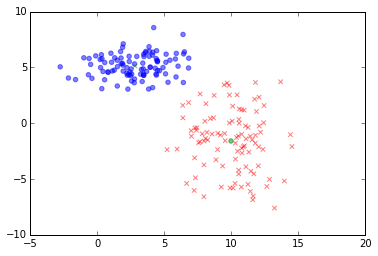

In [85]:
group_df['actual'], center, incorrect = k_means(feature_df,
                                                group_df,
                                                k=2,
                                                distance_metric=distance.cityblock,
                                                show_stats=True)
plot_groups(feature_df, group_df, center)

incorrect_samples=1


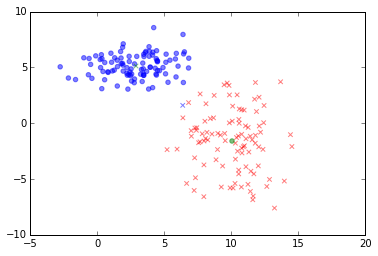

In [86]:
group_df['actual'], center, incorrect = k_means(feature_df,
                                                group_df,
                                                k=2,
                                                distance_metric=distance.chebyshev,
                                                show_stats=False)
plot_groups(feature_df, group_df, center)

Note the one misgrouped sample (a blue cross) at roughly (6,1).

incorrect_samples=0


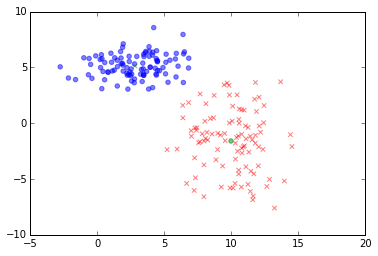

In [105]:
cov_matrix = feature_df.cov().as_matrix()
distance_mahalanobis = lambda x,c: distance.mahalanobis(x,c,inv(cov_matrix)) 

group_df['actual'], center, incorrect = k_means(feature_df,
                                                group_df,
                                                k=2,
                                                distance_metric=distance_mahalanobis)
plot_groups(feature_df, group_df, center)

Exploring the "not-so-easy" dataset
---------------------------------

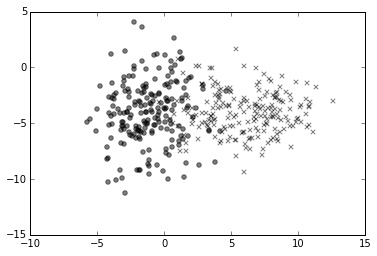

In [183]:
feature_df, group_df = load_feature_group_matrices("not-as-easy.mat", plot=True)

Again, groups marked with symbol; these groups are not linearly-separable. First consider Euclidean and Mahalanobis clusters in original, 2D linear space.

group_iter1: samples_changed=None incorrect_samples=169
group_iter2: samples_changed=64 incorrect_samples=113
group_iter3: samples_changed=65 incorrect_samples=56
group_iter4: samples_changed=34 incorrect_samples=32
group_iter5: samples_changed=20 incorrect_samples=28
group_iter6: samples_changed=6 incorrect_samples=32
group_iter7: samples_changed=0 incorrect_samples=32
incorrect_samples=32


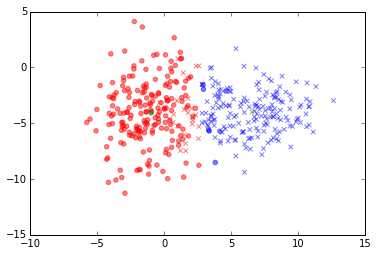

In [108]:
group_df['actual'], center, incorrect = k_means(feature_df,
                                                group_df,
                                                k=2,
                                                distance_metric=distance.euclidean,
                                                show_stats=True)
plot_groups(feature_df, group_df, center)

incorrect_samples=34


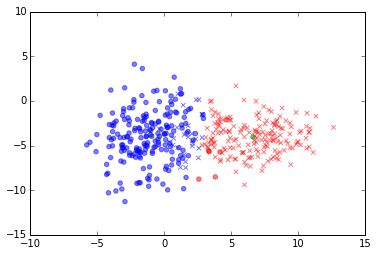

In [112]:
cov_matrix = feature_df.cov().as_matrix()
inv_cov = inv(cov_matrix)
distance_mahalanobis = lambda x,c: distance.mahalanobis(x,c,inv_cov) 

group_df['actual'], center, incorrect = k_means(feature_df, 
                                                group_df, 
                                                k=2, 
                                                distance_metric=distance_mahalanobis)
plot_groups(feature_df, group_df, center)

Both Euclidean and Mahalnobis perform fairly well, leaving 32 and 34 incorrect samples respectively. To explore a more accurate partition, both Euclidean and Mahalanobis were run multiple times each using several non-linear approaches listed below. 

In [ ]:
run_stat = []
feature_df = feature_df.ix[:,["f1","f2"]]
run_multiple_k_means(run_stat, "A) f1,f2", 5, feature_df, group_df)
feature_df["f3"] = feature_df.f1 ** 2
run_multiple_k_means(run_stat, "B) f3=x^2", 5, feature_df, group_df)
feature_df["f3"] = feature_df.f2 **2
run_multiple_k_means(run_stat, "C) f3=y^2", 5, feature_df, group_df)
feature_df["f3"] = feature_df.f2 * feature_df.f2
run_multiple_k_means(run_stat, "D) f3=x*y", 5, feature_df, group_df)
feature_df["f3"] = feature_df.apply(lambda x: math.exp(-1* abs(x.f1)), axis=1)
run_multiple_k_means(run_stat, "E) f3=e^-|x|", 5, feature_df, group_df)
feature_df["f3"] = feature_df.apply(lambda x: math.exp(-1* abs(x.f2)), axis=1)
run_multiple_k_means(run_stat, "F) f3=e^-|y|", 5, feature_df, group_df)
feature_df["f3"] = feature_df.apply(lambda x: math.exp(-1* abs(x.f1 * x.f2)), axis=1)
run_multiple_k_means(run_stat, "G) f3=e^-|x*y|", 5, feature_df, group_df)
feature_df["f3"] = feature_df.apply(lambda x: math.exp(-1* (x.f1 **2)), axis=1)
run_multiple_k_means(run_stat, "H) f3=e^-|x^2|", 5, feature_df, group_df)
feature_df["f3"] = feature_df.apply(lambda x: math.exp(-1* (x.f2 **2)), axis=1)
run_multiple_k_means(run_stat, "I) f3=e^-|y^2|", 5, feature_df, group_df)
feature_df["f3"] = feature_df.apply(lambda x: math.exp(-1* (x.f1 **2 + x.f2 **2)), axis=1)
run_multiple_k_means(run_stat, "J) f3=e^-|x^2 + y^2|", 5, feature_df, group_df)
feature_df["f3"] = feature_df.f1 ** 2
feature_df["f4"] = feature_df.f2 ** 2
run_multiple_k_means(run_stat, "K) f3=x^2,f4=y^2", 5, feature_df, group_df)
feature_df["f3"] = feature_df.f1 ** 2
feature_df["f4"] = feature_df.f2 ** 2
feature_df["f5"] = feature_df.f1 * feature_df.f2
run_multiple_k_means(run_stat, "L) f3=x^2,f4=y^2,f5=x*y", 5, feature_df, group_df)
feature_df = feature_df.ix[:,["f1","f2"]]
feature_df["f3"] = feature_df.apply(lambda x: math.exp(-1* (x.f1 **2)), axis=1)
feature_df["f4"] = feature_df.apply(lambda x: math.exp(-1* (x.f2 **2)), axis=1)
run_multiple_k_means(run_stat, "M) f3=e^-(x^2),f4=e^-(y^2)", 5, feature_df, group_df)


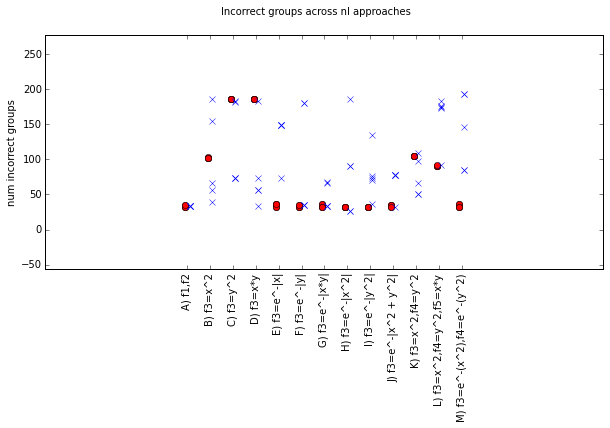

In [213]:
#Graph the run stats
run_stat_df = pd.DataFrame(run_stat)
group_names = []
group_numbers = []
for group_num, (group_name, group) in enumerate(run_stat_df.groupby("description")):
    run_stat_df.ix[group.index, "desc_ord"] = group_num
    group_numbers.append(group_num)
    group_names.append(group_name)
plt.figure(figsize=(10,5))

foo1=run_stat_df.ix[run_stat_df.distance=="euclidean",]
plt.plot(foo1.desc_ord-0.1, foo1.incorrect, 'ro')

foo2=run_stat_df.ix[run_stat_df.distance=="mahalanobis",]
plt.plot(foo2.desc_ord+.1, foo2.incorrect, 'bx')

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(group_numbers, group_names, rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.5)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.25)
plt.suptitle("Incorrect groups across nl approaches")
plt.ylabel('num incorrect groups')
plt.show()

Each symbol represents the number of incorrect samples for a single run of "not-so-easy" dataset.  Each column represents an approach. The red dots are Euclidean distance and the blue crosses are Mahalanobis. 

It is interesting to not that accuracy of Mahalanobis varies widely based on initial centers, while Euclidean is quite stable. Also, while Mahalanobis sometime outperforms individual Euclidean cluster runs, overall, Euclidean does reasonably well. Finally, the non-linear transforms attempted here did not materially improve the clustering over the originally given 2D linear coordinates. 